In [1]:
import os   
import glob
import json
import requests 
import configparser
import pandas as pd
from urllib.parse import urljoin
import storage.client as storage_client
from IPython.display import Image, display
from PIL import ImageDraw
from PIL import Image as PILImage



In [2]:
# list folders only in directory images
folders_list = [os.path.basename(os.path.normpath(x)) for x in glob.glob('images/*/')]

for i, item in enumerate(folders_list):
    print(f'{i+1}. {item}')

print('Enter the number of the item you want to select: ')

1. s1
2. s2
3. s3
4. s4
5. s5
6. w1
7. w2
Enter the number of the item you want to select: 


In [3]:
selection = int(input('Enter the number of the item you want to select: '))
selected_item = folders_list[selection-1]
print(f'You selected {selected_item}.')


You selected s1.


In [4]:
# list images in folder selected_item
blob_images = []
files_list = [os.path.normpath(f) for f in glob.glob(f'images/{selected_item}/*')]
for i, item in enumerate(files_list):
    print(f'{i+1}. {item}', end=': ')
    uploaded = storage_client.uploadLocalFile(item)
    blob_images.append(uploaded.replace('\\', '/')) 
    print(f'uploaded {uploaded}')

1. images\s1\20230408_133914.jpg: uploaded https://godzillasinastorage.blob.core.windows.net/cv4/images\s1\20230408_133914.jpg
2. images\s1\20230408_133918.jpg: uploaded https://godzillasinastorage.blob.core.windows.net/cv4/images\s1\20230408_133918.jpg


In [5]:
blob_images_sas = {"images": [{"url": blob_image + "?" + storage_client.sasForBlob(blob_image)} for blob_image in blob_images]}
blob_images_sas['images'].reverse()
print(json.dumps(blob_images_sas, indent=2))

{
  "images": [
    {
      "url": "https://godzillasinastorage.blob.core.windows.net/cv4/images/s1/20230408_133918.jpg?se=2023-04-15T01%3A09%3A09Z&sp=r&sv=2021-08-06&sr=b&sig=y3Y9hg%2BG0P/l4ip8pdKcE%2B361PW%2BSwX6FZLzOiQK89E%3D"
    },
    {
      "url": "https://godzillasinastorage.blob.core.windows.net/cv4/images/s1/20230408_133914.jpg?se=2023-04-15T01%3A09%3A09Z&sp=r&sv=2021-08-06&sr=b&sig=KRrOFaa%2BHsI/GOaSm7HReyGqW6SEPw1oQJRe/AM6vOc%3D"
    }
  ]
}


In [6]:
for blob_image in blob_images_sas['images']:
    # print(blob_image['url'])
    display(Image(url=blob_image['url'], width=200))


In [7]:

location = selected_item
api_endpoint = os.environ.get('api_endpoint', 'https://<region>.api.cognitive.microsoft.com/')
api_key = os.environ.get('api_key', 'api_key')
# use config parser to read api_key from config file
config = configparser.ConfigParser()
config.read('api.ini')
api_imagestitch = config['API']['imagestitch']

request = blob_images_sas
response = requests.post(
    urljoin(api_endpoint,api_imagestitch), 
    headers={'Ocp-Apim-Subscription-Key': api_key}, 
    json=request)

stitched_image_content = response.content
stitched_image_name = f'images/{location}_stitched.jpg'

BLOB_ACCOUNT = os.environ.get('BLOB_ACCOUNT')
BLOB_STORAGE_KEY = os.environ.get('BLOB_STORAGE_KEY')
BLOB_CONTAINER = os.environ.get('BLOB_CONTAINER')
blob_service = storage_client.BlobServiceClient(
    account_url=f"https://{BLOB_ACCOUNT}.blob.core.windows.net/",
    credential=BLOB_STORAGE_KEY)

blob_client = blob_service.get_container_client(BLOB_CONTAINER)
# container_client = blob_service.get_container_client(container_name)
# blob_client = container_client.get_blob_client(file.filename)
uploaded = blob_client.upload_blob(
    data=stitched_image_content, 
    name=stitched_image_name, 
    overwrite=True)


In [8]:
print(response)
if response.status_code != 200: 
    # print formatted json 
    print(json.dumps(response.json(), indent=2))


<Response [400]>
{
  "error": {
    "code": "InvalidRequest",
    "message": "Failed to estimate the transformation between images during image stitching."
  }
}


In [9]:
if response.status_code == 200:
    print('Stitched image uploaded to blob storage.')
    sas_url = uploaded.url + "?" + storage_client.sasForBlob(uploaded.url)
    print(sas_url)
    display(Image(url=sas_url, width=400))
    

In [10]:
# Image Analysis
api_endpoint = os.environ.get('api_endpoint', 'https://<region>.api.cognitive.microsoft.com/')
api_key = os.environ.get('api_key', 'api_key')

config = configparser.ConfigParser()
config.read('api.ini')
api_imageanalysis = config['API']['imagenalysis']


image_analysis_request = {
    "url": sas_url
}

image_anlysis_response = requests.post(
    urljoin(api_endpoint,api_imageanalysis),
    headers={'Ocp-Apim-Subscription-Key': api_key},
    json=image_analysis_request)



NameError: name 'sas_url' is not defined

In [ ]:
print(image_anlysis_response)
import json

#print formatted json
# print(json.dumps(response.json(), indent=2))

img_boxes = image_anlysis_response.json()
img_boxes.keys()


img_metadata = img_boxes.get('imageMetadata', [])
img_products = img_boxes.get('products', [])
img_gaps = img_boxes.get('gaps', [])
print(f'gaps: {len(img_gaps)}')
print(f'products: {len(img_products)}')

# print(img_gaps[0])

bb_gaps = [ [(bb['boundingBox']['x'], bb['boundingBox']['y']), 
   (bb['boundingBox']['x']+bb['boundingBox']['w'], bb['boundingBox']['y']+bb['boundingBox']['h'])]
 for bb in img_gaps]


<Response [200]>
gaps: 14
products: 226


In [ ]:
pilimg = PILImage.open(requests.get(sas_url, stream=True).raw)
pilimg.show()

In [ ]:
img_before = pilimg.copy()
print(type(img_before))

<class 'PIL.Image.Image'>


In [ ]:
# Process Gaps

# draw rectangles from bb_gaps
for bb in bb_gaps:
    ImageDraw.Draw(pilimg).rectangle(bb, outline="red", width=15)
    ImageDraw.Draw(pilimg).text(
        (bb[0][0]+10, bb[0][1]+5), 
        'Gap', 
        fill="red",
        )    


In [ ]:
#resize image

pilimg = pilimg.resize((int(pilimg.width/4), int(pilimg.height/4)))

In [ ]:
pilimg.show()

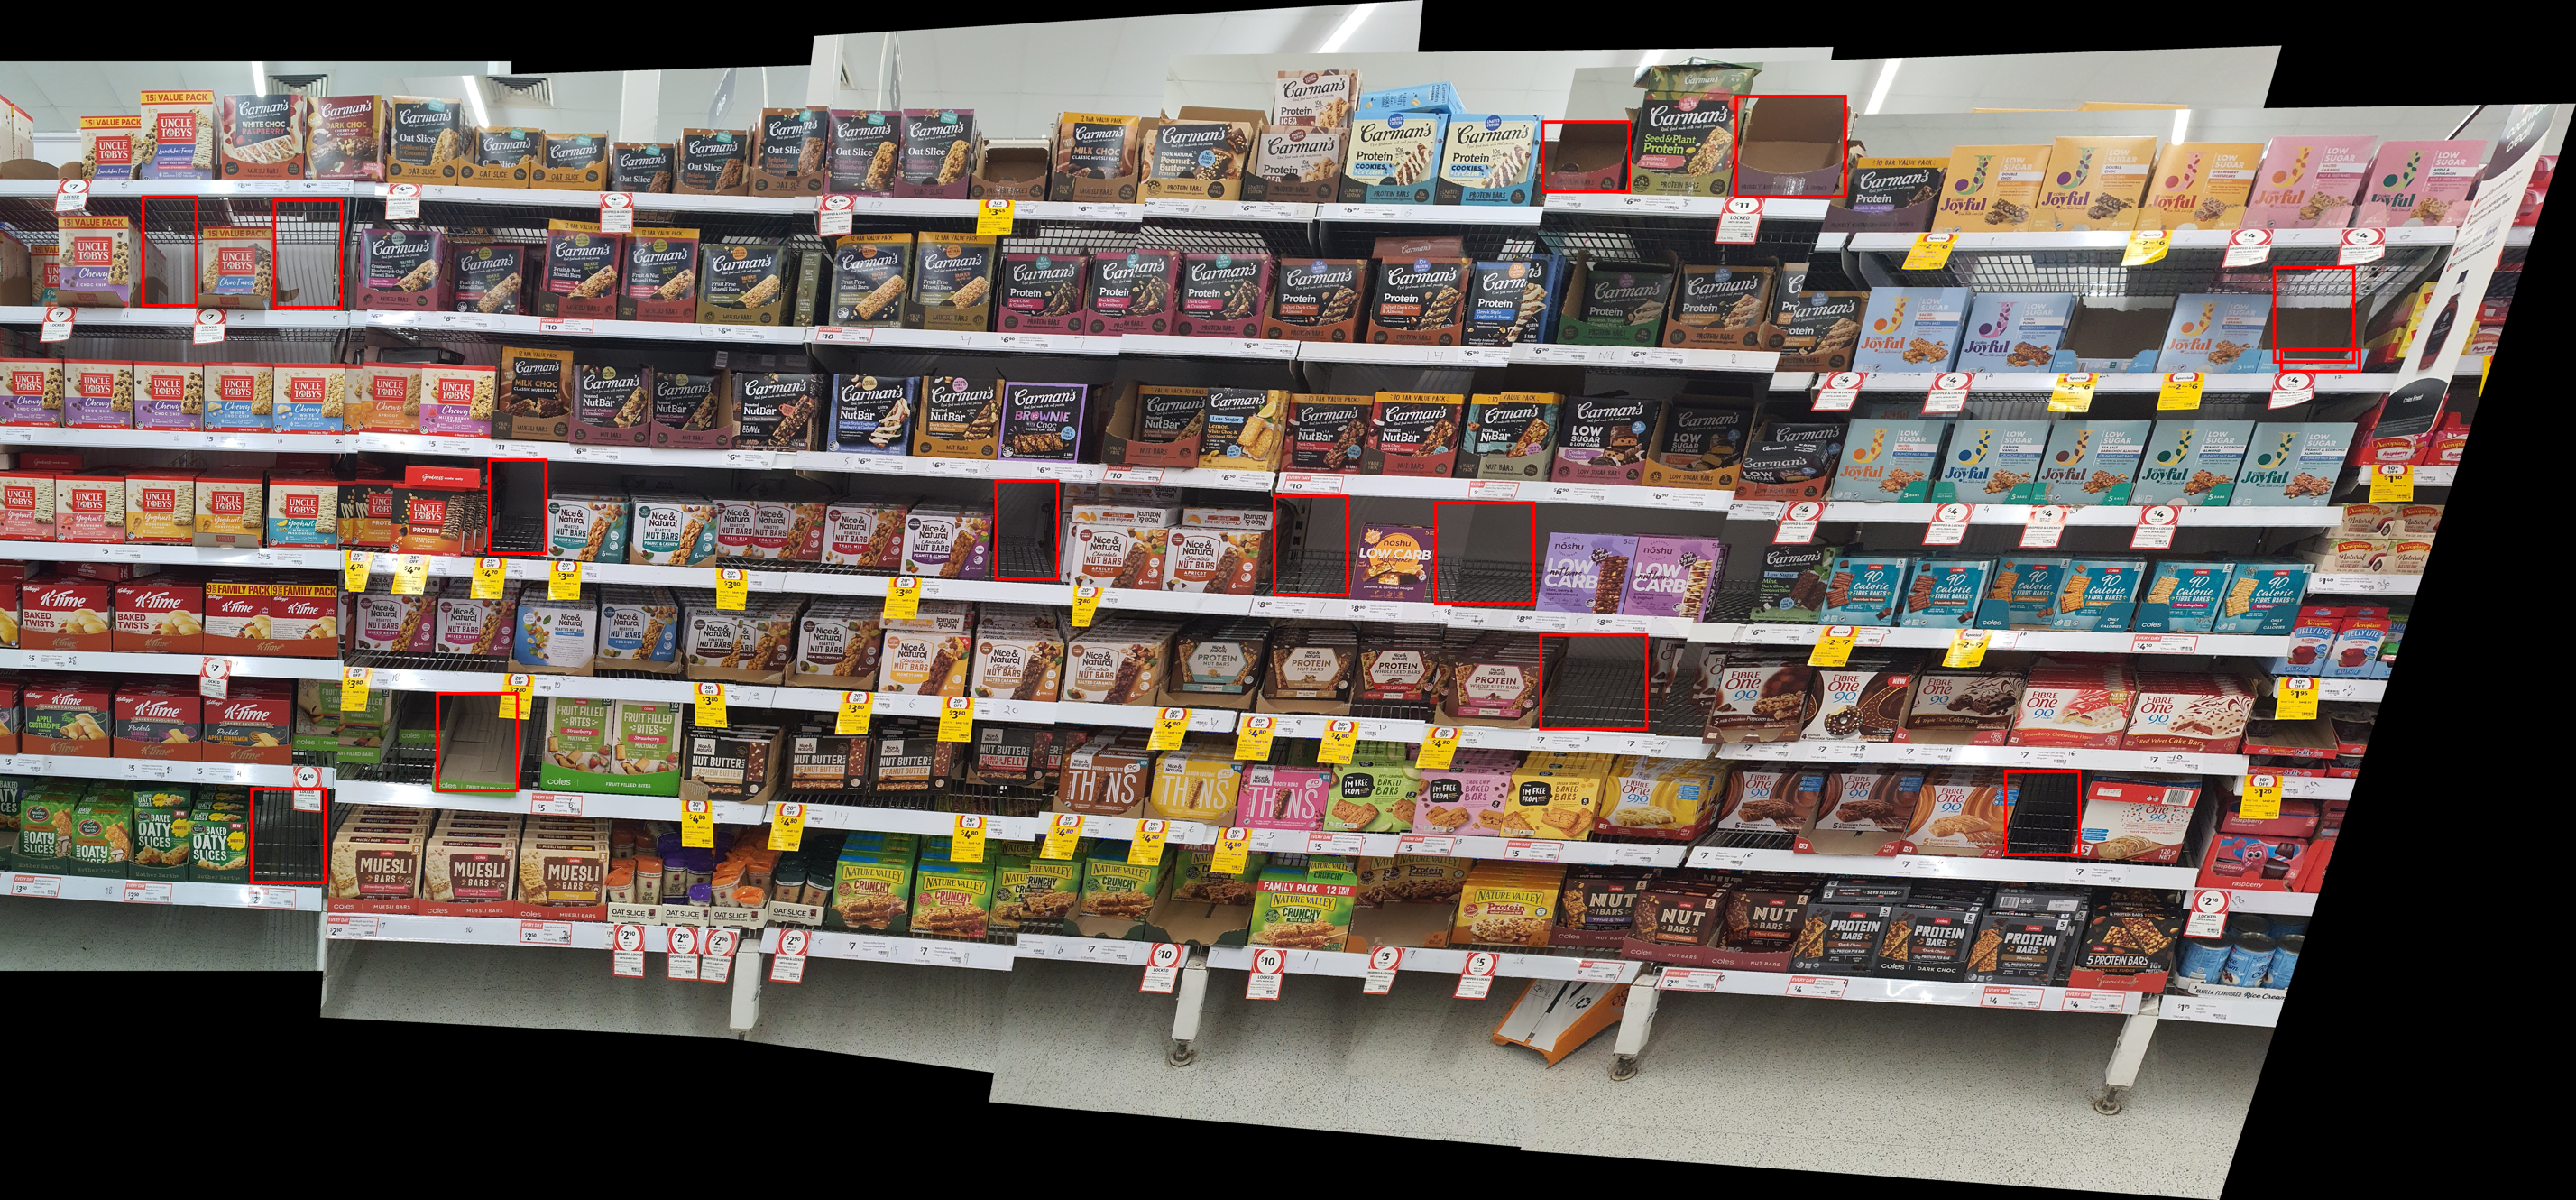

In [ ]:
# pilimg.show()
display(pilimg)

In [ ]:
analysed_image_name = f'images/{location}_analysed.jpg'
uploaded = blob_client.upload_blob(
    data=pilimg.tobytes(), 
    name=analysed_image_name, 
    overwrite=True)

In [ ]:
print(img_products[0])

# convert to a dataframe

df = pd.DataFrame(img_products)
# classifications is a list of dict as follows [{'confidence': 0.9701688, 'label': 'product'}], extract the label and confidence into their own columns
df['label'] = df['classifications'].apply(lambda x: x[0]['label'])
df['confidence'] = df['classifications'].apply(lambda x: x[0]['confidence'])
display(df.head())
# summarise product counts
display(df['label'].value_counts())

{'id': '1', 'boundingBox': {'x': 895, 'y': 1612, 'w': 312, 'h': 296}, 'classifications': [{'confidence': 0.9448199, 'label': 'product'}]}


id                                 boundingBox   
0  1   {'x': 895, 'y': 1612, 'w': 312, 'h': 296}  \
1  2  {'x': 1207, 'y': 1605, 'w': 317, 'h': 315}   
2  3    {'x': 98, 'y': 3055, 'w': 392, 'h': 294}   
3  4   {'x': 545, 'y': 2101, 'w': 306, 'h': 310}   
4  5   {'x': 586, 'y': 1605, 'w': 301, 'h': 296}   

                                    classifications    label  confidence  
0   [{'confidence': 0.9448199, 'label': 'product'}]  product    0.944820  
1   [{'confidence': 0.9437798, 'label': 'product'}]  product    0.943780  
2   [{'confidence': 0.9402189, 'label': 'product'}]  product    0.940219  
3  [{'confidence': 0.93768764, 'label': 'product'}]  product    0.937688  
4   [{'confidence': 0.9351221, 'label': 'product'}]  product    0.935122

label
product    226
Name: count, dtype: int64